# Gaining early insights from text

## Getting an overview of the data with Pandas

### Get Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import regex as re
import nltk
from textacy.text_utils import KWIC
import random
from collections import Counter
from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('un-general-debates-blueprint.csv')
#df.sample(frac=0.1)
df

session  year country  country_name                            speaker  \
0          25  1970     ALB       Albania                            Mr. NAS   
1          25  1970     ARG     Argentina                 Mr. DE PABLO PARDO   
2          25  1970     AUS     Australia                        Mr. McMAHON   
3          25  1970     AUT       Austria                 Mr. KIRCHSCHLAEGER   
4          25  1970     BEL       Belgium                         Mr. HARMEL   
...       ...   ...     ...           ...                                ...   
7502       70  2015     YEM         Yemen  Mr. Abdrabuh Mansour Hadi Mansour   
7503       70  2015     YUG    Yugoslavia               Mr. Tomislav Nikolić   
7504       70  2015     ZAF  South Africa                         Jacob Zuma   
7505       70  2015     ZMB        Zambia             Mr. Edgar Chagwa Lungu   
7506       70  2015     ZWE      Zimbabwe                      Robert Mugabe   

       position                                               text  
0           NaN  33: May I first convey to our President the co...  
1           NaN  177.\t : It is a fortunate coincidence that pr...  
2           NaN  100.\t  It is a pleasure for me to extend to y...  
3           NaN  155.\t  May I begin by expressing to Ambassado...  
4           NaN  176. No doubt each of us, before coming up to ...  
...         ...                                                ...  
7502  President  On behalf of the people and the Government of ...  
7503  President  \nSeventy years have passed since the establis...  
7504  President  I should like to congratulate the President an...  
7505  President  I would like to begin by thanking the Secretar...  
7506  President  Allow me at the outset to extend to Mr. Mogens...  

[7507 rows x 7 columns]

In [3]:
df.columns

Index(['session', 'year', 'country', 'country_name', 'speaker', 'position',
       'text'],
      dtype='object')

In [4]:
df.dtypes

session          int64
year             int64
country         object
country_name    object
speaker         object
position        object
text            object
dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session       7507 non-null   int64 
 1   year          7507 non-null   int64 
 2   country       7507 non-null   object
 3   country_name  7507 non-null   object
 4   speaker       7480 non-null   object
 5   position      4502 non-null   object
 6   text          7507 non-null   object
dtypes: int64(2), object(5)
memory usage: 410.7+ KB


### Calculating summary statistics for columns

In [6]:
df['length'] = df['text'].str.len()
df.describe().T

count          mean          std     min      25%      50%      75%  \
session  7507.0     49.610763    12.892155    25.0     39.0     51.0     61.0   
year     7507.0   1994.610763    12.892155  1970.0   1984.0   1996.0   2006.0   
length   7507.0  17967.281604  7860.038463  2362.0  12077.0  16424.0  22479.5   

             max  
session     70.0  
year      2015.0  
length   72041.0

In [7]:
df[['country', 'speaker']].describe(include='O').T

count unique            top freq
country  7507    199            ISL   46
speaker  7480   5428  Seyoum Mesfin   12

## Checking for missing data

In [8]:
df.isna().sum()

session            0
year               0
country            0
country_name       0
speaker           27
position        3005
text               0
length             0
dtype: int64

In [9]:
df['speaker'].fillna('unknown', inplace=True)

In [10]:
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

George W. Bush        4
Mr. George W. Bush    2
George Bush           1
Bush                  1
Mr. George W Bush     1
Name: speaker, dtype: int64

### Plotting Value Distributions

<AxesSubplot:>

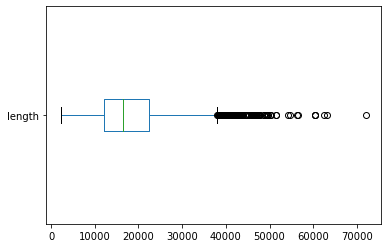

In [11]:
df['length'].plot(kind='box', vert=False)

<AxesSubplot:ylabel='Frequency'>

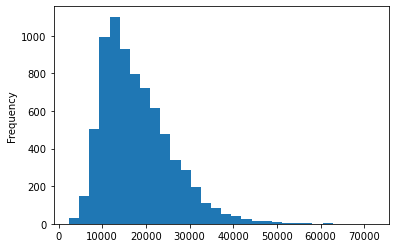

In [12]:
df['length'].plot(kind='hist', bins=30)

### Comparing Value Distributions Across Categories

In [13]:
where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])
sns.catplot(data=df[where], x='country', y='length', kind='box')
sns.catplot(data=df[where], x='country', y='length', kind='violin')

### Visualizing Developments over Time

<AxesSubplot:title={'center':'Number of countries'}, xlabel='year'>

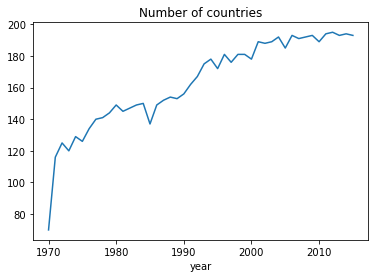

In [14]:
df.groupby('year').size().plot(title='Number of countries')

In [15]:
df.groupby('year').agg({'length': 'mean'})\
    .plot(title='Avg. Speech Length', ylim=(0,30000))

<AxesSubplot:title={'center':'Avg. Speech Length'}, xlabel='year'>

In [16]:
#df['year']=df['time'].dt.year
#df['week']=df['time'].dt.strftime("%Y/Week %W")

#dt.date , dt.year, dt.quarter, dt.hour, dt.month, dt.week

## Building a simple text processing pipeline

### Performing Tokenization with Regular Expressions

In [17]:
def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

text = "Let's defeat SARS-CoV-2 together in 2021!"
tokens = tokenize(text)
print("|".join(tokens))

Let|s|defeat|SARS-CoV-2|together|in


### Treating Stop Words 

In [18]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/damienmellot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [20]:
include_stopwords = {'dear', 'regards', 'must', 'would', 'also'}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

### Processing a Pipeline with One line of Code

In [21]:
pipeline = [str.lower, tokenize, remove_stop]

In [22]:
def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

prepare(text, pipeline)

['let', 'defeat', 'sars-cov-2', 'together']

In [23]:
df['tokens'] = df['text'].apply(prepare, pipeline = pipeline)

In [24]:
df['num_tokens'] = df['tokens'].map(len)

## Word Frequency Analysis

### Counting Words with a Counter

In [25]:
tokens = tokenize("She likes my cats and my cats like my sofa")
counter = Counter(tokens)
print(counter)

Counter({'my': 3, 'cats': 2, 'She': 1, 'likes': 1, 'and': 1, 'like': 1, 'sofa': 1})


In [26]:
more_tokens = tokenize('She likes dogs and cats')
counter.update(more_tokens)
print(counter)

Counter({'my': 3, 'cats': 3, 'She': 2, 'likes': 2, 'and': 2, 'like': 1, 'sofa': 1, 'dogs': 1})


In [27]:
counter = Counter()
df['tokens'].map(counter.update)
print(counter.most_common(5))

[('nations', 124508), ('united', 120763), ('international', 117223), ('world', 89421), ('countries', 85734)]


In [28]:
def count_words(df, column='tokens', preprocess=None, min_freq=2):
    
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
    
    # create counter and run through all data
    counter = Counter()
    df[column].map(update)
    
    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

freq_df = count_words(df)
freq_df.head(5)

freq
token                
nations        124508
united         120763
international  117223
world           89421
countries       85734

In [29]:
count_words(df, column='text', preprocess=lambda text: re.findall(r'\w{10,}', text))

freq
token                
international  106974
development     51334
Government      35528
Organization    33763
developing      25177
...               ...
enfranchising       2
interrelate         2
compositions        2
extensiveness       2
subcommission       2

[11236 rows x 1 columns]

## Creating a Frequency Diagram

In [30]:
ax = freq_df.head(15).plot(kind='barh', width=0.95)
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

## Creating Word Clouds

In [31]:
text = df.query("year==2015 and country=='USA'")['text'].values[0]
wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

In [32]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    
    wc = WordCloud(width=800, height=400,
                   background_color='black', colormap='Paired',
                   max_font_size=150, max_words=max_words)
    
    # convert DataFrame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq
        
    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token : freq for (token, freq) in counter.items()
                                if token not in stopwords}
    wc.generate_from_frequencies(counter)
    
    plt.title(title)
    
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')

In [33]:
freq_2015_df = count_words(df[df['year']==2015])
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [34]:
wordcloud(freq_2015_df['freq'], max_words=100)

In [35]:
wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_df.head(50).index)

## Ranking with TF-IDF

In [36]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):
    
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))
        
    # count tokens
    counter = Counter()
    df[column].map(update)
    
    # create DataFrame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df    

In [37]:
idf_df = compute_idf(df)
# high IDF means rare (interesting) term
idf_df.sample(5)

<ipython-input-36-624aac9ed88d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


df       idf
token                    
nine        381  3.080792
jurmala       2  8.330444
upsurge     140  4.081949
unexpected  122  4.219570
xvii         10  6.721006

In [38]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

In [39]:
freq_1970 = count_words(df[df['year'] == 1970])
freq_2015 = count_words(df[df['year'] == 2015])

freq_1970['tfidf'] = freq_1970['freq'] * idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq'] * idf_df['idf']

# wordcloud(freq_df['freq'], title='All Years', subplot=(1,3,1))
wordcloud(freq_1970['freq'], title='1970 - TF', 
          stopwords=['twenty-fifth', 'twenty-five'])

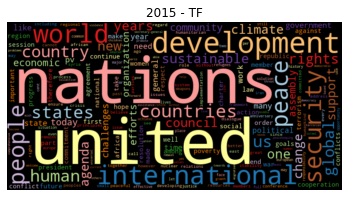

In [40]:
wordcloud(freq_2015['freq'], title='2015 - TF', 
          stopwords=['seventieth'])

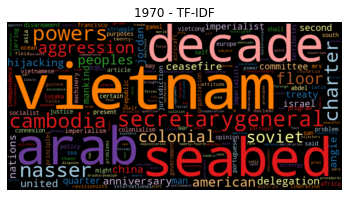

In [41]:
wordcloud(freq_1970['tfidf'], title='1970 - TF-IDF', 
          stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])

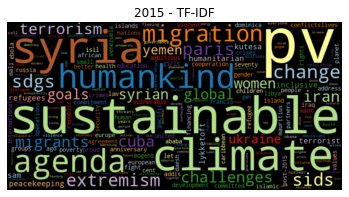

In [50]:
wordcloud(freq_2015['tfidf'], title='2015 - TF-IDF', 
          stopwords=['seventieth'])

## Finding a Keyword in Context (KWIC)

In [43]:
def kwic(doc_series, keyword, window=35, print_samples=5):
    
    def add_kwic(text):
        
        kwic_list.extend(KWIC(text, keyword, ignore_case=True,
                              window_width=window, print_only=False))
    
    kwic_list = []
    doc_series.map(add_kwic)
    
    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)}" + \
              f" contexts for '{keyword}': " )
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))
              

In [44]:
random.seed(22) ###
kwic(df[df['year'] == 2015]['text'], 'sdgs', window=50, print_samples=5)

5 random samples out of 73 contexts for 'sdgs': 
 for the future of our planet and its people. The   SDGs   are a tangible manifestation of the capacity of t
, on the one hand, we are expected to achieve the   SDGs   and to demonstrate dramatic development progress 
would like to lead by example in implementing the   SDGs   in Bangladesh. Attaching due importance to the SD
era to that of the Sustainable Development Goals (  SDGs  ). We applaud all the Chairs of the major United N
es. Today, the new Sustainable Development Goals (  SDGs  ) aspire to that same vision. The Assembly has the


## Analyzing N-Grams

In [45]:
def ngrams(tokens, n=2, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

text = "The visible manifestation of the global climate change"
tokens = tokenize(text)
print("|".join(ngrams(tokens, 2)))

The visible|visible manifestation|manifestation of|of the|the global|global climate|climate change


In [46]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]

print("Bigrams:", "|".join(ngrams(tokens, 2, stopwords=stopwords)))
print("Trigrams:", "|".join(ngrams(tokens, 3, stopwords=stopwords)))

Bigrams: The visible|visible manifestation|global climate|climate change
Trigrams: The visible manifestation|global climate change


In [47]:
df['bigrams'] = df['text'].apply(prepare, pipeline=[str.lower, tokenize])\
                          .apply(ngrams, n=2, stopwords=stopwords)

count_words(df, 'bigrams').head(5)

freq
token                          
united nations           103236
international community   27786
general assembly          27096
security council          20961
human rights              19856

<ipython-input-36-624aac9ed88d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


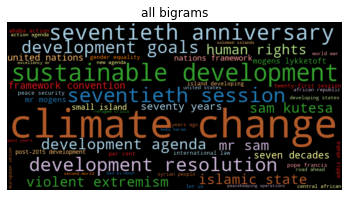

In [48]:
# concatenate existing IDF DataFrame with bigram IDFs
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=10)])

freq_df = count_words(df[df['year']==2015], 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']
wordcloud(freq_df['tfidf'], title='all bigrams', max_words=50)

In [49]:
where = freq_df.index.str.contains('climate')
wordcloud(freq_df[where]['freq'], title='"climate" bigrams', max_words=50)

## Comparing Frequencies across Time-Intervals and Categories

### Creating Frequency Timelines

In [51]:
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k,0) for k in keywords]

In [54]:
keywords = ['nuclear', 'terrorism', 'climate', 'freedom']
tokens = ['nuclear', 'climate', 'climate', 'freedom', 'climate', 'freedom']

print(count_keywords(tokens, keywords))

[1, 0, 3, 2]


In [56]:
def count_keywords_by(df, by, keywords, column='tokens'):
    
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by] # copy the grouping column(s)
                     
    return freq_df.groupby(by=by).sum().sort_values(by)

In [63]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)
freq_df.head()

nuclear  terrorism  climate  freedom
year                                      
1970      192          7       18      128
1971      275          9       35      205
1972      393        379       74      280
1973      347        124       79      266
1974      478         24       71      316

In [69]:
freq_df.plot(kind='line', figsize=(10, 6))

<AxesSubplot:xlabel='year'>

In [70]:
random.seed(23) ###
# analyzing mentions of 'climate' before 1980
kwic(df.query('year < 1980')['text'], 'climate', window=35, print_samples=5)

5 random samples out of 581 contexts for 'climate': 
ation with a view to replacing the   climate   of fear, mistrust and hatred by to
ntributing to the maintenance of a   climate   of peace, harmony and understandin
ges in the international political   climate  . There is increasing awareness of 
rian-Israeli front, have created a   climate   which favors the continuation of n
 that, far from noting a promising   climate   in the most critical areas of inte


### Creating Frequency Heatmaps

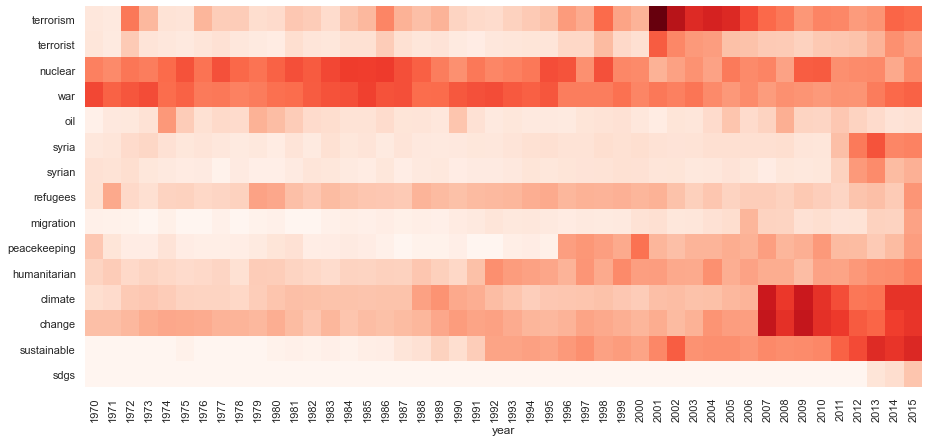

In [76]:
keywords = ['terrorism', 'terrorist', 'nuclear', 'war', 'oil',
            'syria', 'syrian', 'refugees', 'migration', 'peacekeeping', 
            'humanitarian', 'climate', 'change', 'sustainable', 'sdgs'] 

freq_df = count_keywords_by(df, by='year', keywords=keywords)

# compute relative frequencies based on a total number of tokens per year
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)
# apply square root as sublinear filter for better contrast
freq_df = freq_df.apply(np.sqrt)


plt.figure(figsize=(15, 7))
sns.set(font_scale=1)
sns.heatmap(data=freq_df.T,
            xticklabels=True, yticklabels=True, cbar=False, cmap='Reds')

sns.set(font_scale=1)

# Closing